# A comprehensive guide to Feature Selection using Wrapper methods in Python

Author: Vikas Verma

Article from [analyticsvidhya](https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [14]:
from sklearn.datasets import load_boston
import pandas as pd
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load dataset

In [2]:
boston = load_boston()
print(boston.data.shape)         # for dataset dimension
print(boston.feature_names)      # for feature names
print(boston.target)             # for target variable
print(boston.DESCR)

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 

# Convert to dataframe

In [3]:
bos = pd.DataFrame(boston.data, columns=boston.feature_names)
bos['Price'] = boston.target
X = bos.drop('Price', 1) # feature matrix
y = bos['Price'] # target feature
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Forward selection

In [4]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if (min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [5]:
forward_selection(X,y)

['LSTAT',
 'RM',
 'PTRATIO',
 'DIS',
 'NOX',
 'CHAS',
 'B',
 'ZN',
 'CRIM',
 'RAD',
 'TAX']

## Implementing Forward selection using built-in functions in Python

In [6]:
sfs = SFS(
    LinearRegression(),
    k_features=11,
    forward=True,
    floating=False,
    scoring='r2',
    cv=0
)

In [7]:
sfs.fit(X, y)
sfs.k_feature_names_ # to get the final set of features

('CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT')

# Backward elimination

In [8]:
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if (max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

In [9]:
backward_elimination(X, y)

['CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

## Implementing Backward elimination using built-in functions in Python

In [10]:
sbs = SFS(
    LinearRegression(),
    k_features=11,
    forward=False,
    floating=False,
    cv=0
)

In [11]:
sbs.fit(X, y)
sbs.k_feature_names_

('CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT')

# Additional note

In [12]:
sfs1 = SFS(
    estimator=LinearRegression(),
    k_features=(3,11),
    forward=True,
    floating=False,
    cv=0
)

In [13]:
sfs1.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(),
                          k_features=(3, 11))

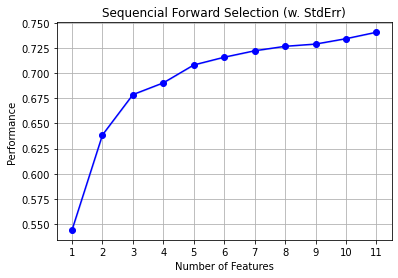

In [15]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequencial Forward Selection (w. StdErr)')
plt.grid()
plt.show()

# Bi-directional elimination (step-wise selection)

In [16]:
def stepwise_selection(data, target, SL_in=0.05, SL_out=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if (min_p_value < SL_in):
            best_features.append(new_pval.idxmin())
            while len(best_features) > 0:
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if (max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

In [17]:
stepwise_selection(X, y)

['LSTAT',
 'RM',
 'PTRATIO',
 'DIS',
 'NOX',
 'CHAS',
 'B',
 'ZN',
 'CRIM',
 'RAD',
 'TAX']

## Implementing bi-directional elimination using built-in functions in Python

In [18]:
sffs = SFS(
    LinearRegression(),
    k_features=(3,11),
    forward=True,
    floating=True,
    cv=0
)
sffs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(), floating=True,
                          k_features=(3, 11))

In [19]:
sffs.k_feature_names_

('CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT')